# Understanding Dataset





### To identify online payment fraud with machine learning, we need to train a machine learning model for classifying fraudulent and non-fraudulent payments. For this, we need a dataset containing information about online payment fraud, so that we can understand what type of transactions lead to fraud.

### Below are all the columns from the dataset we are using here:

#### step: represents a unit of time where 1 step equals 1 hour
#### type: type of online transaction
#### amount: the amount of the transaction
#### nameOrig: customer starting the transaction
#### oldbalanceOrg: balance before the transaction
#### newbalanceOrig: balance after the transaction
#### nameDest: recipient of the transaction
#### oldbalanceDest: initial balance of recipient before the transaction
#### newbalanceDest: the new balance of recipient after the transaction
#### isFraud: fraud transaction

In [ ]:
import pandas as pd
import numpy as np
import plotly.express as px

import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import time

# Scaling
from sklearn.preprocessing import MinMaxScaler, StandardScaler


from sklearn.model_selection import train_test_split

from imblearn.under_sampling import RandomUnderSampler
from sklearn.utils import class_weight


from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report,confusion_matrix

# Hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_csv("/content/drive/MyDrive/ML_Datasets/onlinefraud.csv")

In [ ]:
eda_data = pd.read_csv("/content/drive/MyDrive/ML_Datasets/onlinefraud.csv")

In [ ]:
data.shape

(6362620, 11)

In [ ]:
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


EDA


In [ ]:
# Exploring transaction type
print(eda_data.type.value_counts())

CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: type, dtype: int64


In [ ]:
type = eda_data["type"].value_counts()
transactions = type.index
quantity = type.values
figure = px.pie(data, values=quantity, names=transactions, hole = 0.5, title="Distribution of Transaction Type")
figure.show()

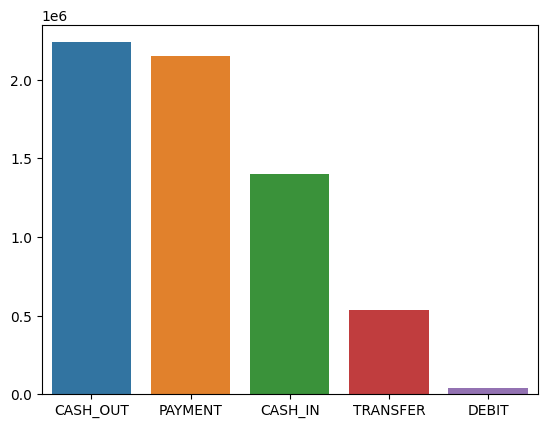

In [ ]:
sns.barplot(x = eda_data.type.value_counts().index, y = eda_data.type.value_counts().values)
plt.show()

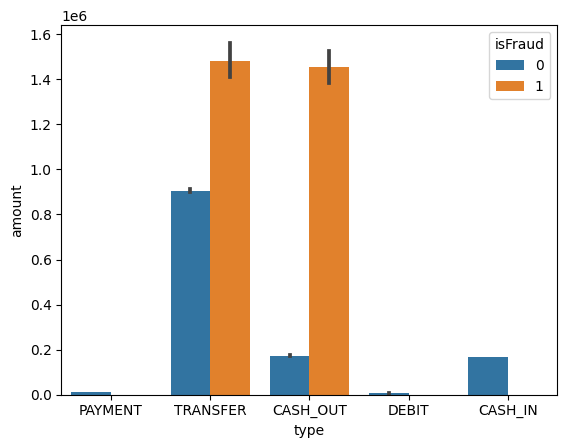

In [ ]:
sns.barplot(x="type", y="amount", hue="isFraud", data=eda_data)
# plt.ylim(eda_data['amount'].min(), eda_data['amount'].max())
plt.show()

In [ ]:
isFraud_df  = eda_data[eda_data['isFraud']==1]

<Axes: >

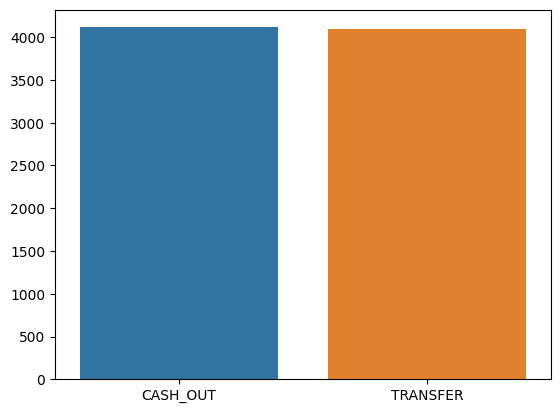

In [ ]:
sns.barplot(x = isFraud_df.type.value_counts().index, y = isFraud_df.type.value_counts().values)

In [ ]:
print(isFraud_df.type.value_counts())

CASH_OUT    4116
TRANSFER    4097
Name: type, dtype: int64


In [ ]:
result = isFraud_df.groupby('type').agg({'amount': ['mean', 'min', 'max']}).round(2)
#result = np.round(reuslt,2)
result

amount                  
                mean   min         max
type                                  
CASH_OUT  1455102.59   0.0  10000000.0
TRANSFER  1480891.67  63.8  10000000.0

In [ ]:
eda_data.groupby(['isFraud','type']).agg({'amount': ['count','mean', 'min', 'max','std', 'var']}).round(2)

amount                                              \
                    count        mean    min          max         std   
isFraud type                                                            
0       CASH_IN   1399284   168920.24   0.04   1915267.90   126508.26   
        CASH_OUT  2233384   173917.16   0.01   2847566.62   131222.24   
        DEBIT       41432     5483.67   0.55    569077.51    13318.54   
        PAYMENT   2151495    13057.60   0.02    238637.98    12556.45   
        TRANSFER   528812   906229.01   2.60  92445516.64  1874155.26   
1       CASH_OUT     4116  1455102.59   0.00  10000000.00  2393841.79   
        TRANSFER     4097  1480891.67  63.80  10000000.00  2414890.38   

                                
                           var  
isFraud type                    
0       CASH_IN   1.600434e+10  
        CASH_OUT  1.721928e+10  
        DEBIT     1.773834e+08  
        PAYMENT   1.576644e+08  
        TRANSFER  3.512458e+12  
1       CASH_OUT  5.730478e+12  
        TRANSFER  5.831696e+12

In [ ]:
eda_data['isFraud'].value_counts()

0    6354407
1       8213
Name: isFraud, dtype: int64

In [ ]:
CrosstabResult=pd.crosstab(index=eda_data.type,columns=eda_data.isFraud)
CrosstabResult

isFraud,0,1
type,,
CASH_IN,1399284,0
CASH_OUT,2233384,4116
DEBIT,41432,0
PAYMENT,2151495,0
TRANSFER,528812,4097


In [ ]:
data.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


In [ ]:
data.drop('isFlaggedFraud',axis=1,inplace=True)

In [ ]:
data['isFraud'].value_counts()

0    6354407
1       8213
Name: isFraud, dtype: int64

In [ ]:
# Now, let’s have a look at whether this dataset has any null values or not
data.isna().values.any()

False

In [ ]:

print(data.isnull().sum())

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64


Just for making sure that no missing values are found

In [ ]:
# Select all duplicate rows based on all columns
data[data.duplicated(keep=False)] 

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud


In [ ]:
obj = (data.dtypes == 'object')
object_cols = list(obj[obj].index)
print("Categorical variables:", len(object_cols))

int_ = (data.dtypes == 'int')
num_cols = list(int_[int_].index)
print("Integer variables:", len(num_cols))

fl = (data.dtypes == 'float')
fl_cols = list(fl[fl].index)
print("Float variables:", len(fl_cols))


Categorical variables: 3
Integer variables: 3
Float variables: 5


In [ ]:
numerical_features = data.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_features

['step',
 'amount',
 'oldbalanceOrg',
 'newbalanceOrig',
 'oldbalanceDest',
 'newbalanceDest',
 'isFraud',
 'isFlaggedFraud']

In [ ]:
numerical_features_to_plot = ['step','amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest']

In [ ]:
object_features = data.select_dtypes(include=['object']).columns.tolist()
object_features

['type', 'nameOrig', 'nameDest']

In [ ]:
# Calculate and print the skewness of each numerical column
for col in numerical_features_to_plot:
    skewness = data[col].skew()
    print(f"Skewness of {col}: {skewness}")

Skewness of step: 0.37517688846984765
Skewness of amount: 30.99394948249038
Skewness of oldbalanceOrg: 5.249136420603121
Skewness of newbalanceOrig: 5.176884001159233
Skewness of oldbalanceDest: 19.921757915791062
Skewness of newbalanceDest: 19.352302057660165


Features are highly skewed except step column, there must be outliers in data

In [ ]:
numerical_features_to_plot.remove('step')

Identify outliers

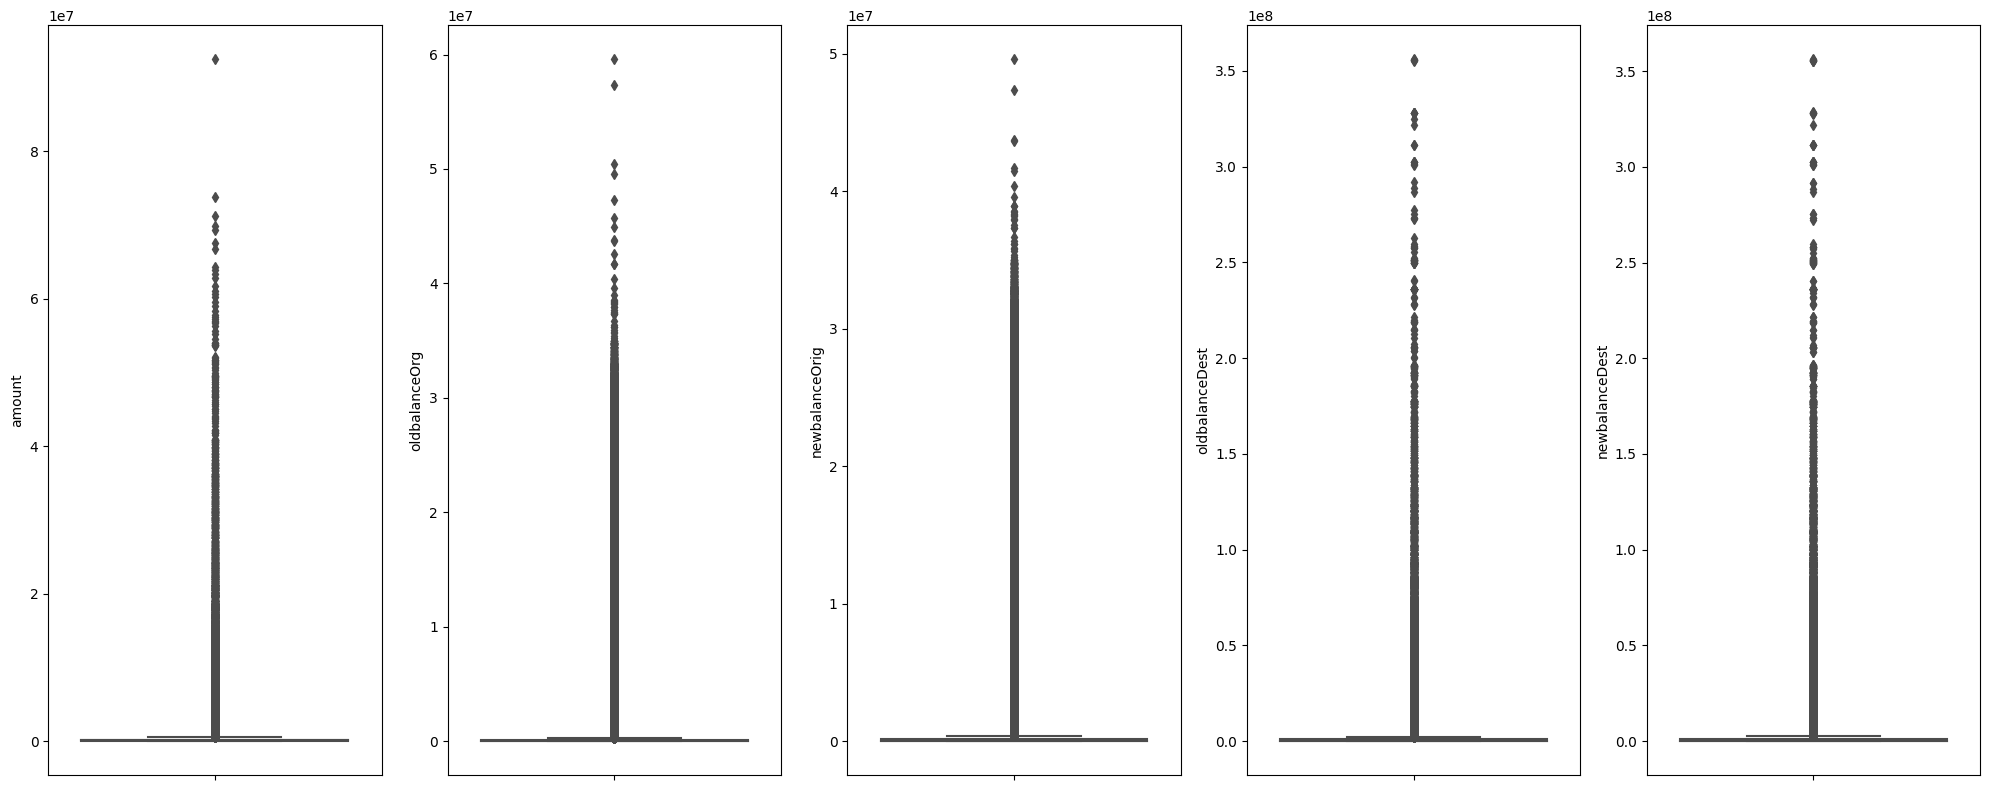

In [ ]:
# Identify using boxplot
plt.figure(figsize=(20,8))
for i in range(0,len(numerical_features_to_plot)):
    plt.subplot(1, len(numerical_features_to_plot), i+1)
    sns.boxplot(y=data[numerical_features_to_plot[i]], color='orange')
    plt.tight_layout()

In [ ]:

for i in numerical_features_to_plot:
    lower = data[i].quantile(0.10)
    upper = data[i].quantile(0.90)
    data[i] = np.where(data[i] <lower, lower,data[i])
    data[i] = np.where(data[i] >upper, upper,data[i])
    print('Feature: ',i)
    print('Skewness value: ',data[i].skew())
    print('\n')

Feature:  amount
Skewness value:  0.8046460444556197


Feature:  oldbalanceOrg
Skewness value:  2.249361299814406


Feature:  newbalanceOrig
Skewness value:  2.2262847493216786


Feature:  oldbalanceDest
Skewness value:  1.4173123924260833


Feature:  newbalanceDest
Skewness value:  1.3593024983493058




Distribution after removing outliers

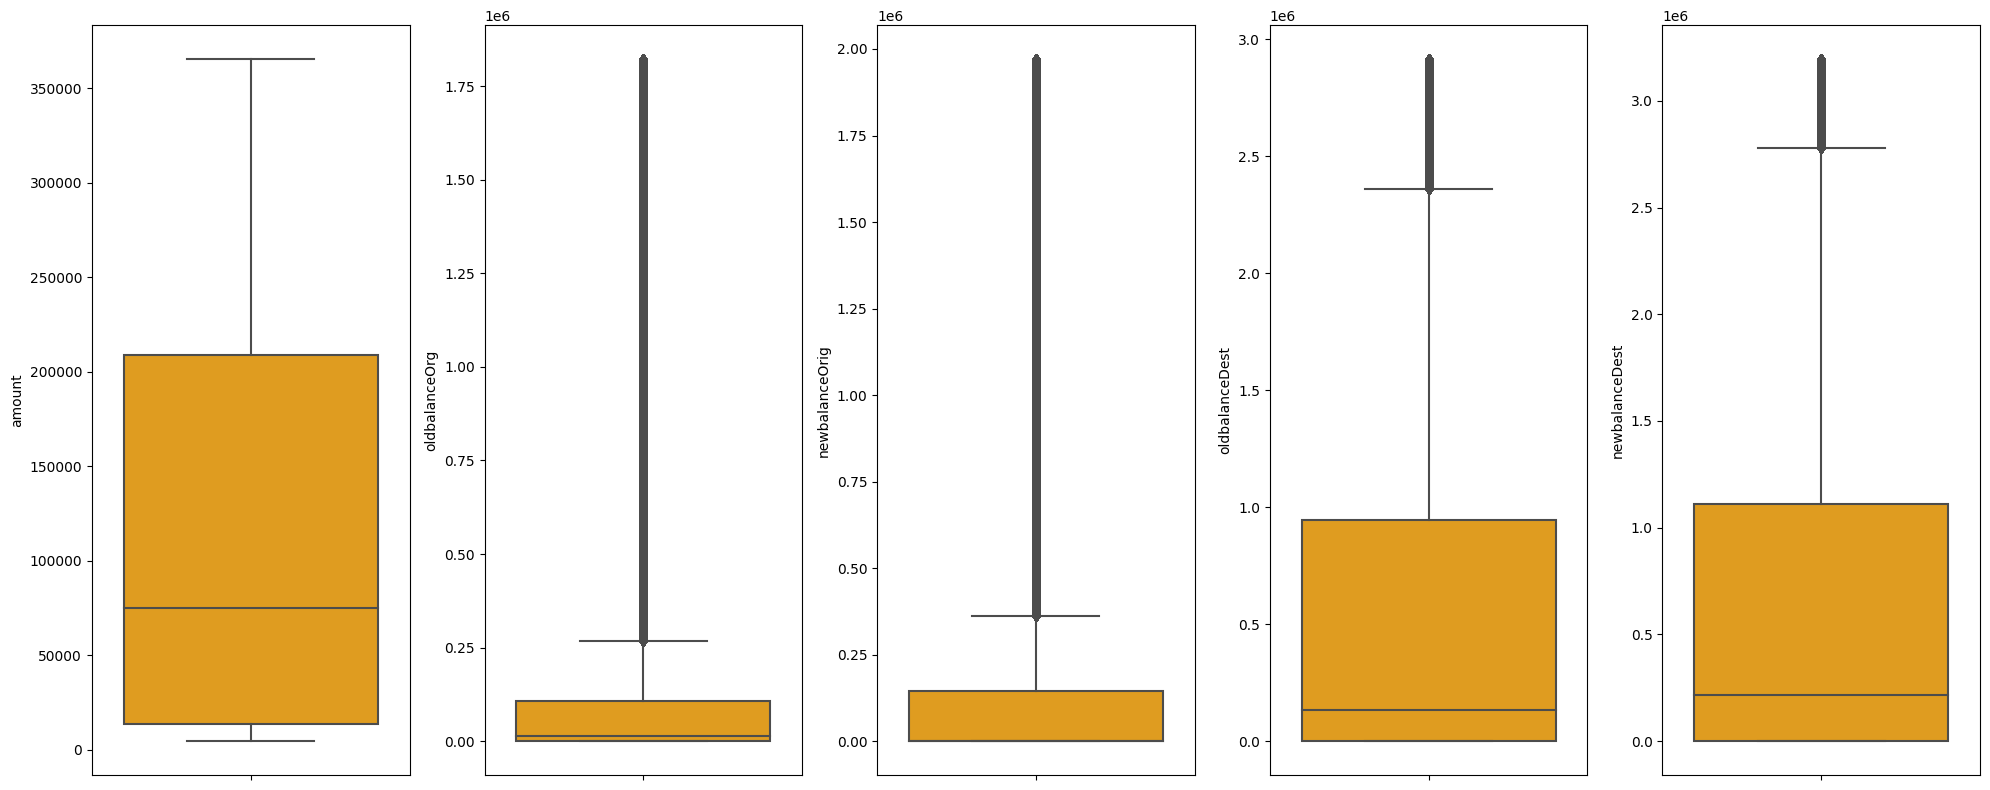

In [ ]:
# Identify using boxplot
plt.figure(figsize=(20,8))
for i in range(0,len(numerical_features_to_plot)):
    plt.subplot(1, len(numerical_features_to_plot), i+1)
    sns.boxplot(y=data[numerical_features_to_plot[i]], color='orange')
    plt.tight_layout()

We didn't remove the outliers, but replacing with upper bound and lower bound. And we can see in the visualization above, there is significant improvements.

Feature Transformation : Log transform

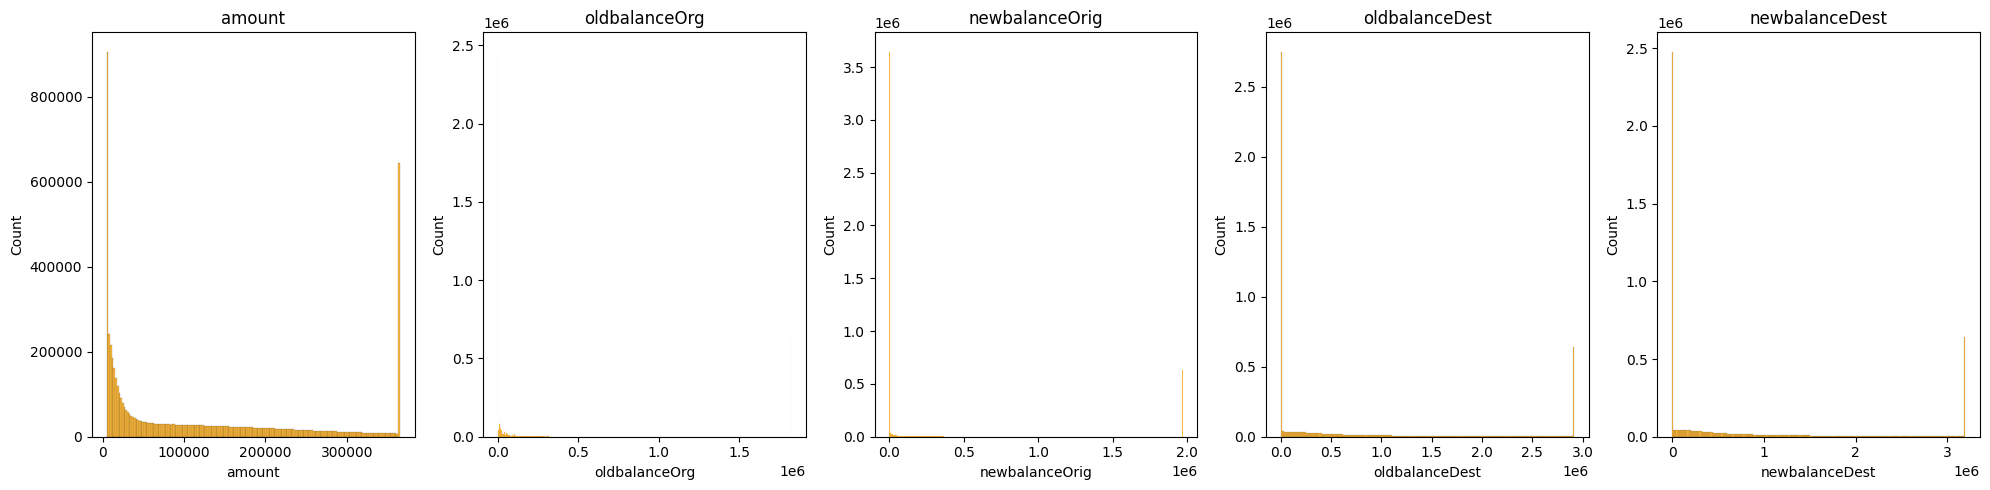

In [ ]:
# Check data distribution
fig, axes = plt.subplots(1, len(numerical_features_to_plot), figsize=(20,5))

for i, ax in enumerate(axes):
    sns.histplot(data[numerical_features_to_plot[i]], color='orange', ax=ax)
    ax.set_title(numerical_features_to_plot[i])

plt.tight_layout()


In [ ]:
# Apply log transformation
for col in numerical_features_to_plot:
    data[col] = (data[col]+1).apply(np.log)

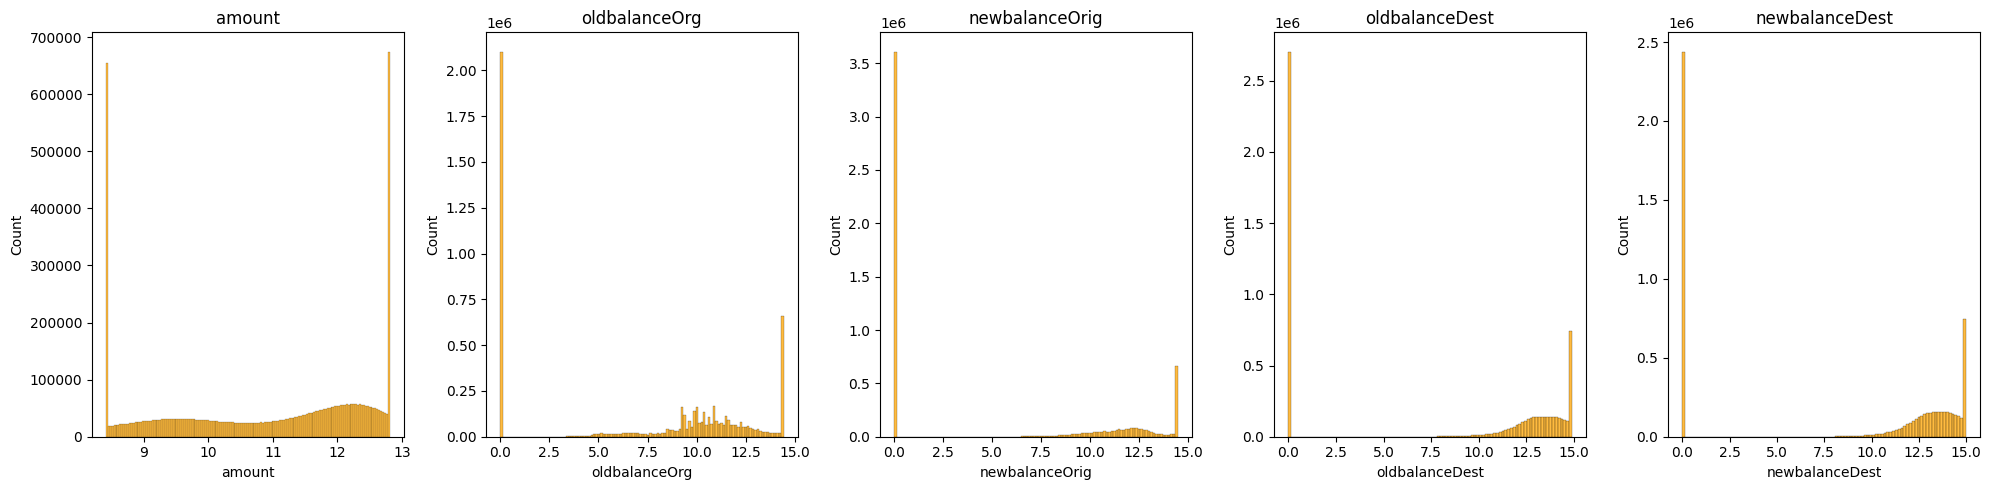

In [ ]:
# Check data distribution
fig, axes = plt.subplots(1, len(numerical_features_to_plot), figsize=(20,5))

for i, ax in enumerate(axes):
    sns.histplot(data[numerical_features_to_plot[i]], color='orange', ax=ax)
    ax.set_title(numerical_features_to_plot[i])

plt.tight_layout()

In [ ]:
for i in numerical_features_to_plot:
    print('Feature: ',i)
    print('Skewness value: ',data[i].skew())
    print('\n')

Feature:  amount
Skewness value:  -0.3150122992967299


Feature:  oldbalanceOrg
Skewness value:  -0.34975195181546503


Feature:  newbalanceOrig
Skewness value:  0.391580135790705


Feature:  oldbalanceDest
Skewness value:  -0.23237069505067393


Feature:  newbalanceDest
Skewness value:  -0.40645330982973243




Feature Scaling : Standardization

In [ ]:
# Apply standardization
for col in numerical_features_to_plot:
    data[col]= StandardScaler().fit_transform(data[col].values.reshape(len(data), 1))

In [ ]:
data.describe().round(2)

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6362620.00,6362620.00,6362620.00,6362620.00,6362620.00,6362620.00,6362620.00,6362620.0
mean,243.40,0.00,-0.00,-0.00,0.00,-0.00,0.00,0.0
std,142.33,1.00,1.00,1.00,1.00,1.00,0.04,0.0
min,1.00,-1.63,-1.33,-0.85,-1.15,-1.25,0.00,0.0
25%,156.00,-0.91,-1.33,-0.85,-1.15,-1.25,0.00,0.0
50%,239.00,0.23,0.41,-0.85,0.62,0.61,0.00,0.0
75%,335.00,0.90,0.78,1.08,0.92,0.86,0.00,0.0
max,743.00,1.27,1.29,1.50,1.08,1.02,1.00,1.0


In [ ]:
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,-1.115112,C1231006815,0.862943,1.095095,M1979787155,-1.147905,-1.251768,0,0
1,1,PAYMENT,-1.631815,C1666544295,0.484910,0.751496,M2044282225,-1.147905,-1.251768,0,0
2,1,TRANSFER,-1.631815,C1305486145,-0.380119,-0.854240,C553264065,-1.147905,-1.251768,1,0
3,1,CASH_OUT,-1.631815,C840083671,-0.380119,-0.854240,C38997010,0.346305,-1.251768,1,0
4,1,PAYMENT,-1.002493,C2048537720,0.606786,0.821905,M1230701703,-1.147905,-1.251768,0,0


In [ ]:
data["type"] = data["type"].map({"CASH_OUT": 1, "PAYMENT": 2, "CASH_IN": 3, "TRANSFER": 4, "DEBIT": 5})
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,2,-1.115112,C1231006815,0.862943,1.095095,M1979787155,-1.147905,-1.251768,0,0
1,1,2,-1.631815,C1666544295,0.484910,0.751496,M2044282225,-1.147905,-1.251768,0,0
2,1,4,-1.631815,C1305486145,-0.380119,-0.854240,C553264065,-1.147905,-1.251768,1,0
3,1,1,-1.631815,C840083671,-0.380119,-0.854240,C38997010,0.346305,-1.251768,1,0
4,1,2,-1.002493,C2048537720,0.606786,0.821905,M1230701703,-1.147905,-1.251768,0,0


In [ ]:
# Load the data
X = data.drop(columns=['nameOrig','nameDest','isFraud'])
y = data['isFraud']

In [ ]:
X.shape


(6362620, 8)

In [ ]:
y.shape

(6362620,)

In [ ]:
# Split the data into train and test sets
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:

def get_result(model,model_name,train_x, test_x, train_y, test_y):
    name = model_name
    print('Started execution for', name)
    start_time = time.time()
    
    model.fit(train_x, train_y)
    print('Fitting completed for', name)
    fit_time = time.time() - start_time
    
    # Predict the labels for train and test data and generate the classification report
    y_train_pred = model.predict(train_x)
    y_test_pred = model.predict(test_x)
    
    # Classification report and confusion matrix for train data
    print('Classification report for', name, 'on train data:')
    print(classification_report(train_y, y_train_pred))
    print('Confusion matrix for', name, 'on train data:')
    cm_train = confusion_matrix(train_y, y_train_pred)
    print(cm_train)
    
    # Classification report and confusion matrix for test data
    print('Classification report for', name, 'on test data:')
    print(classification_report(test_y, y_test_pred))
    print('Confusion matrix for', name, 'on test data:')
    cm_test = confusion_matrix(test_y, y_test_pred)
    print(cm_test)
    
    total_time = time.time() - start_time
    print('Total execution time for', name, ':', total_time, 'seconds')


In [ ]:
rf_model = RandomForestClassifier(class_weight='balanced')

In [ ]:
get_result(rf_model,'random forest clf',train_x, test_x, train_y, test_y)

Started execution for random forest clf
Fitting completed for random forest clf
Classification report for random forest clf on train data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   5083503
           1       1.00      1.00      1.00      6593

    accuracy                           1.00   5090096
   macro avg       1.00      1.00      1.00   5090096
weighted avg       1.00      1.00      1.00   5090096

Confusion matrix for random forest clf on train data:
[[5083503       0]
 [      2    6591]]
Classification report for random forest clf on test data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270904
           1       0.98      0.78      0.87      1620

    accuracy                           1.00   1272524
   macro avg       0.99      0.89      0.93   1272524
weighted avg       1.00      1.00      1.00   1272524

Confusion matrix for random forest clf on test data:
[[1

In [ ]:
# rf_model.feature_importances_
# Plot feature importances
def plot_feature_importance(model,name):
  name = name
  plt.figure()
  plt.title('Feature Importances - ' + name)
  plt.bar(range(train_x.shape[1]), model.feature_importances_)
  plt.xticks(range(train_x.shape[1]), train_x.columns, rotation=90)
  plt.show()

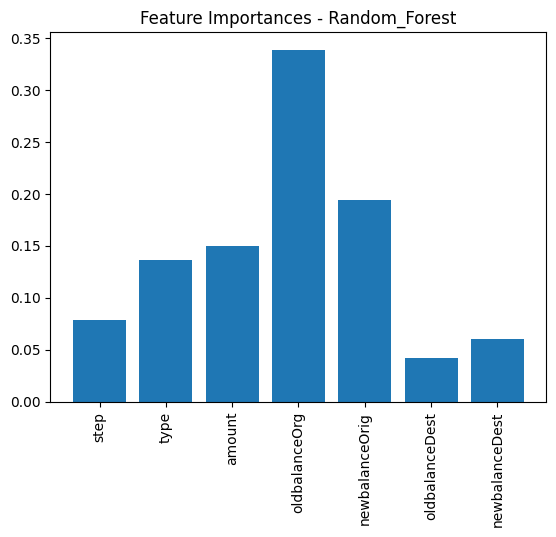

In [ ]:
plot_feature_importance(rf_model,'Random_Forest')

In [ ]:
data.drop(['oldbalanceDest','newbalanceDest'],axis=1,inplace=True)

**Using Random Under Sampling Technique**

In [ ]:
# Apply RandomUnderSampler to undersample the majority class
rus = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = rus.fit_resample(train_x, train_y)

In [ ]:
Logistic_Regression=LogisticRegression(class_weight='balanced')

In [ ]:
get_result(Logistic_Regression,'Logistic_Regression',X_train_resampled, test_x, y_train_resampled, test_y)

Started execution for Logistic_Regression
Fitting completed for Logistic_Regression


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Classification report for Logistic_Regression on train data:
              precision    recall  f1-score   support

           0       0.95      0.92      0.93      6593
           1       0.93      0.95      0.94      6593

    accuracy                           0.94     13186
   macro avg       0.94      0.94      0.94     13186
weighted avg       0.94      0.94      0.94     13186

Confusion matrix for Logistic_Regression on train data:
[[6090  503]
 [ 344 6249]]
Classification report for Logistic_Regression on test data:
              precision    recall  f1-score   support

           0       1.00      0.93      0.96   1270904
           1       0.02      0.94      0.03      1620

    accuracy                           0.93   1272524
   macro avg       0.51      0.93      0.50   1272524
weighted avg       1.00      0.93      0.96   1272524

Confusion matrix for Logistic_Regression on test data:
[[1176248   94656]
 [     93    1527]]
Total execution time for Logistic_Regression : 2

In [ ]:
DecisionTreeClassifier_clf=DecisionTreeClassifier()

In [ ]:
get_result(DecisionTreeClassifier_clf,'DecisionTreeClassifier',X_train_resampled, test_x, y_train_resampled, test_y)

Started execution for DecisionTreeClassifier
Fitting completed for DecisionTreeClassifier
Classification report for DecisionTreeClassifier on train data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6593
           1       1.00      1.00      1.00      6593

    accuracy                           1.00     13186
   macro avg       1.00      1.00      1.00     13186
weighted avg       1.00      1.00      1.00     13186

Confusion matrix for DecisionTreeClassifier on train data:
[[6593    0]
 [   0 6593]]
Classification report for DecisionTreeClassifier on test data:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99   1270904
           1       0.09      0.99      0.16      1620

    accuracy                           0.99   1272524
   macro avg       0.54      0.99      0.58   1272524
weighted avg       1.00      0.99      0.99   1272524

Confusion matrix for DecisionTreeClassifier

In [ ]:
XGBClassifier_model = XGBClassifier(random_state=42, eval_metric = 'logloss')

In [ ]:
get_result(XGBClassifier_model,'XGBClassifier',X_train_resampled, test_x, y_train_resampled, test_y)

Started execution for XGBClassifier
Fitting completed for XGBClassifier
Classification report for XGBClassifier on train data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6593
           1       1.00      1.00      1.00      6593

    accuracy                           1.00     13186
   macro avg       1.00      1.00      1.00     13186
weighted avg       1.00      1.00      1.00     13186

Confusion matrix for XGBClassifier on train data:
[[6593    0]
 [   0 6593]]
Classification report for XGBClassifier on test data:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00   1270904
           1       0.12      1.00      0.22      1620

    accuracy                           0.99   1272524
   macro avg       0.56      0.99      0.61   1272524
weighted avg       1.00      0.99      0.99   1272524

Confusion matrix for XGBClassifier on test data:
[[1259284   11620]
 [      4    1616]]


**If the performance of a model trained using random undersampling is not satisfactory on the test data, it may be more effective to use all the available training data observations. However, if the available data is highly class imbalanced, using the weight_class parameter could be beneficial to address this issue. This parameter assigns higher weights to the minority class samples during training, which can help the model learn from these examples and improve its performance on the test data.**

In [ ]:
# Calculate weights using sklearn
dict1={0: 0.2,1: 0.8}
sklearn_weights3 = class_weight.compute_class_weight(class_weight=dict1,y=data['isFraud'],classes=np.unique(y))
sklearn_weights3

array([0.2, 0.8])

In [ ]:
print(f'The weights for the majority class is {sklearn_weights3[0]*2:.3f}')
print(f'The weights for the minority class is {sklearn_weights3[1]*2:.3f}')

The weights for the majority class is 0.400
The weights for the minority class is 1.600


In [ ]:
log_reg = LogisticRegression(class_weight=dict1)

In [ ]:
get_result(log_reg,'LogisticRegression',train_x, test_x, train_y, test_y)

Started execution for LogisticRegression


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Fitting completed for LogisticRegression
Classification report for LogisticRegression on train data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   5083503
           1       0.96      0.53      0.68      6593

    accuracy                           1.00   5090096
   macro avg       0.98      0.76      0.84   5090096
weighted avg       1.00      1.00      1.00   5090096

Confusion matrix for LogisticRegression on train data:
[[5083367     136]
 [   3116    3477]]
Classification report for LogisticRegression on test data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270904
           1       0.97      0.52      0.68      1620

    accuracy                           1.00   1272524
   macro avg       0.98      0.76      0.84   1272524
weighted avg       1.00      1.00      1.00   1272524

Confusion matrix for LogisticRegression on test data:
[[1270874      30]
 [    770     850]]

Logistic Regression, achieving 100% accuracy on both training and testing data. However, the recall score for the minority class is low, indicating potential issues in correctly identifying positive cases. The model execution time was approximately 70 seconds.

In [ ]:
DecisionTreeClassifier = DecisionTreeClassifier(class_weight='balanced')

In [ ]:
get_result(DecisionTreeClassifier,'DecisionTreeClassifier blanced weight',train_x, test_x, train_y, test_y)

Started execution for DecisionTreeClassifier blanced weight
Fitting completed for DecisionTreeClassifier blanced weight
Classification report for DecisionTreeClassifier blanced weight on train data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   5083503
           1       1.00      1.00      1.00      6593

    accuracy                           1.00   5090096
   macro avg       1.00      1.00      1.00   5090096
weighted avg       1.00      1.00      1.00   5090096

Confusion matrix for DecisionTreeClassifier blanced weight on train data:
[[5083503       0]
 [      0    6593]]
Classification report for DecisionTreeClassifier blanced weight on test data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270904
           1       0.89      0.84      0.86      1620

    accuracy                           1.00   1272524
   macro avg       0.94      0.92      0.93   1272524
weighted av

Decision Tree Classifier with balanced weight. The model achieved an accuracy of 100% on the training data and an accuracy of 100% on the test data. The recall score for the minority class improved significantly from the previous model, indicating better performance in correctly identifying positive cases. The model execution time was approximately 73 seconds.

In summary, the Decision Tree Classifier with balanced weight showed improvement in identifying positive cases compared to the previous model, achieving high accuracy on both training and testing data.

In [ ]:
DecisionTreeClassifier_Tuned = DecisionTreeClassifier(class_weight={0: 0.2, 1: 0.8}, max_depth=9,max_features='log2', min_samples_leaf=14,min_samples_split=5, random_state=42)

In [ ]:
get_result(DecisionTreeClassifier_Tuned ,'Decision Tree Classifier after Tuned',train_x, test_x, train_y, test_y)

Started execution for Decision Tree Classifier after Tuned
Fitting completed for Decision Tree Classifier after Tuned
Classification report for Decision Tree Classifier after Tuned on train data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   5083503
           1       0.91      0.73      0.81      6593

    accuracy                           1.00   5090096
   macro avg       0.95      0.87      0.91   5090096
weighted avg       1.00      1.00      1.00   5090096

Confusion matrix for Decision Tree Classifier after Tuned on train data:
[[5083024     479]
 [   1770    4823]]
Classification report for Decision Tree Classifier after Tuned on test data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270904
           1       0.91      0.73      0.81      1620

    accuracy                           1.00   1272524
   macro avg       0.95      0.87      0.91   1272524
weighted avg    

The Decision Tree Classifier model after tuning had an accuracy of 100% on the train and test data sets. Precision, recall, and F1-score were also high for both classes in both sets. The execution time was 39.54 seconds. Overall, the model shows good performance.

In [ ]:
get_result(rf_model,'random forest clf',train_x, test_x, train_y, test_y)

Started execution for random forest clf
Fitting completed for random forest clf
Classification report for random forest clf on train data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   5083503
           1       1.00      1.00      1.00      6593

    accuracy                           1.00   5090096
   macro avg       1.00      1.00      1.00   5090096
weighted avg       1.00      1.00      1.00   5090096

Confusion matrix for random forest clf on train data:
[[5083503       0]
 [      2    6591]]
Classification report for random forest clf on test data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270904
           1       0.97      0.78      0.87      1620

    accuracy                           1.00   1272524
   macro avg       0.99      0.89      0.93   1272524
weighted avg       1.00      1.00      1.00   1272524

Confusion matrix for random forest clf on test data:
[[1

The Random Forest Classifier model had the highest accuracy on both the training and testing datasets compared to the Decision Tree Classifier models. However, the Random Forest Classifier took significantly longer to train. The Decision Tree Classifier with Tuning had the highest precision and recall scores for the minority class on the testing dataset, indicating better performance in detecting fraudulent transactions.

In [ ]:
RandomForestClassifier_Tuned = RandomForestClassifier(class_weight={0: 0.09736842105263158,1: 0.9026315789473685},max_depth=50, n_estimators=150, random_state=42)

In [ ]:
get_result(RandomForestClassifier_Tuned ,'RandomForest Classifier after Tuned',train_x, test_x, train_y, test_y)

Started execution for RandomForest Classifier after Tuned
Fitting completed for RandomForest Classifier after Tuned
Classification report for RandomForest Classifier after Tuned on train data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   5083503
           1       1.00      1.00      1.00      6593

    accuracy                           1.00   5090096
   macro avg       1.00      1.00      1.00   5090096
weighted avg       1.00      1.00      1.00   5090096

Confusion matrix for RandomForest Classifier after Tuned on train data:
[[5083503       0]
 [      1    6592]]
Classification report for RandomForest Classifier after Tuned on test data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270904
           1       0.98      0.79      0.88      1620

    accuracy                           1.00   1272524
   macro avg       0.99      0.90      0.94   1272524
weighted avg       1.

The tuned random forest model has achieved the highest accuracy score of 1.0 on the training data and 0.9988 on the test data. It also has the highest precision and recall scores on both train and test data among all the models that have been trained. The execution time for this model is 2522 seconds which is much higher than the other models, but it is still within a reasonable range for a random forest model with a large dataset. Overall, the tuned random forest model appears to be the best performing model for this dataset.

In [ ]:
XGBClassifier_model = XGBClassifier(random_state=42, eval_metric = 'logloss')

In [ ]:
get_result(XGBClassifier_model,'XGBClassifier',train_x, test_x, train_y, test_y)

Started execution for XGBClassifier
Fitting completed for XGBClassifier
Classification report for XGBClassifier on train data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   5083503
           1       0.99      0.91      0.95      6593

    accuracy                           1.00   5090096
   macro avg       0.99      0.96      0.97   5090096
weighted avg       1.00      1.00      1.00   5090096

Confusion matrix for XGBClassifier on train data:
[[5083430      73]
 [    564    6029]]
Classification report for XGBClassifier on test data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270904
           1       0.97      0.87      0.92      1620

    accuracy                           1.00   1272524
   macro avg       0.98      0.94      0.96   1272524
weighted avg       1.00      1.00      1.00   1272524

Confusion matrix for XGBClassifier on test data:
[[1270859      45]
 [    20

The XGBClassifier achieved an accuracy of 1.0 on the train data and 0.999 on the test data. It performed slightly worse than the random forest classifier on the train data, but slightly better on the test data. However, it had much faster execution time compared to the previous models.

Comparing all the models, the Random Forest Classifier after Tuned has the best performance on the test data with an accuracy of 0.999 and f1-score of 0.88 for detecting fraudulent transactions. It also has a fast execution time compared to the other models. Therefore, we can consider the Random Forest Classifier after Tuned as the best model for detecting fraudulent transactions in this case.

In [ ]:
count_class_0, count_class_1 = train_y.value_counts()
scale_pos_weight = count_class_0 / count_class_1

In [ ]:
# Define the XGBoost model
model_xgb = XGBClassifier(scale_pos_weight=scale_pos_weight)


In [ ]:
get_result(model_xgb,'XGBClassifier',train_x, test_x, train_y, test_y)

Started execution for XGBClassifier
Fitting completed for XGBClassifier
Classification report for XGBClassifier on train data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   5083503
           1       0.51      1.00      0.68      6593

    accuracy                           1.00   5090096
   macro avg       0.76      1.00      0.84   5090096
weighted avg       1.00      1.00      1.00   5090096

Confusion matrix for XGBClassifier on train data:
[[5077261    6242]
 [      0    6593]]
Classification report for XGBClassifier on test data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270904
           1       0.48      0.99      0.64      1620

    accuracy                           1.00   1272524
   macro avg       0.74      0.99      0.82   1272524
weighted avg       1.00      1.00      1.00   1272524

Confusion matrix for XGBClassifier on test data:
[[1269147    1757]
 [     2

For XGBClassifier with scale_pos_weight parameter set to the calculated value of 77.27, the model achieved an accuracy of 1.0 on the train data and an accuracy of 0.996 on the test data. However, the precision, recall, and f1-score for the positive class (fraudulent transactions) were significantly lower than the previous models, indicating that this model is not the best for detecting fraudulent transactions.

Compared to the previous models, the XGBClassifier with scale_pos_weight performed poorly in detecting fraudulent transactions, but had a higher accuracy score on the test data. Therefore, in terms of detecting fraudulent transactions, the best model is the Random Forest Classifier after tuning.

**Observations**

The dataset can be improved in several ways:

Additional features: Some possible features that could be added to the dataset include the geographical location of the transaction, the device used to initiate the transaction, and the time of day when the transaction was made. These features can help provide more context and improve the accuracy of the model.

Data augmentation: The dataset can be augmented by adding more fraudulent transaction data to the dataset. This can be achieved by generating synthetic data or by acquiring more transaction data from other sources.

In [ ]:
#LogisticRegression(C=0.0001, class_weight={0: 0.5, 1: 0.5}, random_state=42)

#DecisionTreeClassifier(class_weight={0: 0.2, 1: 0.8}, max_depth=9,
                      #  max_features='log2', min_samples_leaf=14,
                      #  min_samples_split=5, random_state=42)

#RandomForestClassifier(class_weight={0: 0.09736842105263158,1: 0.9026315789473685},
    #                               max_depth=50, n_estimators=150, random_state=42)

In [ ]:
LogisticRegression_Tuned = LogisticRegression(C=0.0001, class_weight={0: 0.5, 1: 0.5}, random_state=42)

DecisionTreeClassifier_Tuned = DecisionTreeClassifier(class_weight={0: 0.2, 1: 0.8}, max_depth=9,max_features='log2', min_samples_leaf=14,min_samples_split=5, random_state=42)

RandomForestClassifier_Tuned = RandomForestClassifier(class_weight={0: 0.09736842105263158,1: 0.9026315789473685},max_depth=50, n_estimators=150, random_state=42)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, f1_score

# Define the parameter space to search
param_space = {
    'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2],
    'n_estimators': [100, 500, 1000, 1500, 2000],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1],
    'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9, 1],
    'min_child_weight': [1, 3, 5, 7],
}

# Define a custom scoring metric using F1-score
scoring = make_scorer(f1_score, pos_label=1)

# Use StratifiedKFold for cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define XGBoost classifier with default parameters and set scale_pos_weight
xgb_clf = XGBClassifier(scale_pos_weight=1000)

# Use RandomizedSearchCV for hyperparameter tuning
rs_clf = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=param_space,
    n_iter=1000,
    scoring=scoring,
    cv=cv,
    verbose=3,
    n_jobs=-1
)

# Train and tune the model
rs_clf.fit(train_x, train_y, early_stopping_rounds=10, eval_metric='auc', eval_set=[(test_x, test_y)])

# Print the best hyperparameters and score
print("Best Hyperparameters: ", rs_clf.best_params_)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


KeyboardInterrupt: ignored

In [ ]:
# Initiate hyperparameters
weights = np.linspace(0.05, 0.95, 20)
params = {'max_depth':[50],'n_estimators':[100,150], 
          'criterion':['gini', 'entropy'],
          'class_weight': [{0: x, 1: 1.0-x} for x in weights]

          }
# Initiate model
rf_tune = RandomForestClassifier(random_state =  42)
# model = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
#                      param_grid=params,scoring='f1', cv=5)
model = RandomizedSearchCV(rf_tune,params,scoring='f1', cv=5)
# Fit model
model.fit(train_x, train_y)
y_pred = model.predict(test_x)
# Get best estimator
model.best_estimator_

In [ ]:
# Let's do hyperparameter tuning using RandomizesearchCV

# Hyperparameter lists to be tested
max_depth = list(range(1,10)) 
min_samples_split = list(range(5,10)) 
min_samples_leaf = list(range(5,15)) 
max_features = ['sqrt', 'log2'] 
criterion = ['gini','entropy']
splitter = ['best','random']
class_weight = [{0: w, 1: 1.0-w} for w in np.arange(0.1, 1.0, 0.1)]


# Initiate hyperparameters
hyperparameters = dict(max_depth=max_depth, 
                       min_samples_split=min_samples_split, 
                       min_samples_leaf=min_samples_leaf,
                       max_features=max_features,
                       criterion = criterion,
                       splitter = splitter,
                       class_weight = class_weight)

# Initiate model
dt_tun = DecisionTreeClassifier(random_state=42)
model = RandomizedSearchCV(dt_tun, hyperparameters, cv=10, scoring='f1',random_state=42) 
model.fit(train_x, train_y)
y_pred_tun = model.predict(test_x)
model.best_estimator_

In [ ]:
penalty = ['l2','l1','elasticnet']
C = [0.0001, 0.001, 0.002] # Inverse of regularization strength; smaller values specify stronger regularization.
class_weight = [{0: w, 1: 1.0-w} for w in np.arange(0.1, 1.0, 0.1)]
max_iter = [1000, 2000, 5000]
hyperparameters = dict(penalty=penalty, C=C, class_weight=class_weight, max_iter=max_iter)

# Inisiasi model
# Initiate model
logres = LogisticRegression(random_state=42, solver='saga') # Specify solver to 'saga' for elasticnet penalty
model = RandomizedSearchCV(logres, hyperparameters, cv=5, random_state=42, scoring='f1')

# Fitting Model & Evaluation
model.fit(train_x, train_y)
y_pred = model.predict(test_x)
model.best_estimator_